# Part 3. Preprocessing and Feature Engineering

In [1]:
from utils import *

In [2]:
# Read in the data
tweet_stocks = pd.read_pickle('data/tweet_stocks_EDA.pkl')
plt.style.use('fivethirtyeight')

# Data Preprocessing

To get the text ready for machine learning, we will remove punctuation, stopwords, junkwords, and normalize the text by making it lowercase and lemmatizing it.

To extract features from the text, we are going to first clean it of any links, mentions, hashtags, and emojis to preserve the syntax of the tweet. We will be looking at two examples during this process.

We have two tweets from Elon Musk that made headlines for how they affected the stock. August 7th, 2018 caused stocks to jump and May 1st, 2020. Let's take a look at these tweets.

In [4]:
# Sample Text
sample = tweet_stocks[tweet_stocks['username'] == 'elonmusk']
sample['date'] = pd.to_datetime(sample['date'])
sample.set_index('date', inplace=True)

pd.options.display.max_colwidth = 1000
sample_increase = sample['2018-08-07']
sample_tweet_increase = sample_increase[['tweet', 'percent change']]
pct_increase = sample_tweet_increase['percent change'].values*100
print('Tweet Increases Stock by {:.3f}%'.format(pct_increase[0]))
print('========================')
print(sample_tweet_increase[['tweet']].values[0][0], '\n')

Tweet Increases Stock by 10.391%
Investor support is confirmed. Only reason why this is not certain is that it’s contingent on a shareholder vote. Shareholders could either to sell at 420 or hold shares &amp; go private Good morning 😀 Am considering taking Tesla private at $420. Funding secured.  



Both twitter samples need to be cleaned, which needs to be able to conserve the context around the text.

In [5]:
tweet_stocks['text'] = tweet_stocks['tweet'].apply(lambda x: clean_text(x, preserve_syntax=True))

In [6]:
sample = tweet_stocks[tweet_stocks['username'] == 'elonmusk']
sample['date'] = pd.to_datetime(sample['date'])
sample.set_index('date', inplace=True)

sample_increase = sample['2018-08-07']
sample_tweet_increase = sample_increase[['text', 'percent change']]
pct_increase = sample_tweet_increase['percent change'].values*100
print('Cleaned Tweet Increases Stock by {:.3f}%'.format(pct_increase[0]))
print('========================')
print(sample_tweet_increase[['text']].values[0][0], '\n')

Cleaned Tweet Increases Stock by 10.391%
Investor support is confirmed. Only reason why this is not certain is that it is contingent on a shareholder vote. Shareholders could either to sell at 420 or hold shares go private Good morning Am considering taking Tesla private at 420. Funding secured. 



Apart from a few sentences lacking punctuation, the text itself is preserved including capitalization, which will aid in using Spacy's NLP toolkit to extract text features.

### Extracting Text Features

In [7]:
tweet_stocks['number of emojis'] = tweet_stocks['tweet'].apply(lambda x: emoji_counts(x))

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# Remove empty tweets after cleaning

tweet_stocks['tweet length'] = tweet_stocks['text'].apply(lambda x: len(x))
tweet_stocks = tweet_stocks[tweet_stocks['tweet length'] != 0]
tweet_stocks.reset_index(inplace=True, drop=True)

In [10]:
%%time
# Clocked at 14min 20s
df = tweet_stocks.copy(deep=True)
text  = 'text'

df['number of sentences'] = df[text].apply(lambda x: num_sentences(x))
df['number of words'] = df[text].apply(lambda x: num_words(x))
df['avg words per sentence'] = df[text].apply(lambda x: avg_words_per_sentence(x))

count = df[text].apply(lambda x: noun_counts(x))
df['number of nouns'] = 0
for i in range(len(count)):
    df['number of nouns'].iloc[i] = count[i][0]

count = df[text].apply(lambda x: verb_counts(x))
df['number of verbs'] = 0
for i in range(len(count)):
    df['number of verbs'].iloc[i] = count[i][0]

count = df[text].apply(lambda x: stopword_counts(x))
df['number of stopwords'] = 0
for i in range(len(count)):
    df['number of stopwords'].iloc[i] = count[i][0]

count = df[text].apply(lambda x: org_counts(x))
df['number of organizations'] = 0
for i in range(len(count)):
    df['number of organizations'].iloc[i] = count[i][0]

CPU times: user 7min 38s, sys: 34.8 s, total: 8min 13s
Wall time: 8min 42s


In [11]:
tweet_stocks = df

In [12]:
STOP_WORDS = nlp.Defaults.stop_words

In [13]:
sample_increase['text']

date
2018-08-07 16:00:00    Investor support is confirmed. Only reason why this is not certain is that it is contingent on a shareholder vote. Shareholders could either to sell at 420 or hold shares go private Good morning Am considering taking Tesla private at 420. Funding secured.
Name: text, dtype: object

In [14]:
sample_increase['cleaned'] = sample_increase['tweet'].apply(lambda x: clean_text(x, stop_words=STOP_WORDS))

In [15]:
sample_increase[['cleaned']]

,cleaned
date,
2018-08-07 16:00:00,investor support confirm reason certain contingent shareholder vote shareholder sell hold share private good morning consider take tesla private funding secure


We can see from the cleaned text that there are going to be some words that won't be recognized. Let's look at all short words and see if they can be removed.

In [16]:
%%time
# Clocked at 3min 26s
tweet_stocks['cleaned'] = tweet_stocks['text'].apply(lambda x:clean_text(x, stop_words=STOP_WORDS))
tweet_stocks['len_cleaned'] = tweet_stocks['cleaned'].apply(lambda x: len(x))
tweet_stocks[tweet_stocks['len_cleaned'] == 0]

CPU times: user 1min 25s, sys: 2.85 s, total: 1min 28s
Wall time: 1min 30s


,date,tweet,username,mentions,hashtags,video,photos,urls,number of tweets,price,...,tweet length,number of sentences,number of words,avg words per sentence,number of nouns,number of verbs,number of stopwords,number of organizations,cleaned,len_cleaned
1158,2020-10-13 16:00:00,This is how we do it. 👍,Benioff,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,266.829987,...,21,1,6,6.0,0,1,6,0,,0
1241,2021-02-17 16:00:00,The Next ⁦@TIME⁩ 100. https://t.co/moS5ZsvZiO,Benioff,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,247.660004,...,13,1,2,3.0,0,0,2,0,,0
1244,2021-02-22 16:00:00,2021 @TIME NEXT 100 https://t.co/3UsgOGOKWH 2021 @TIME NEXT 100 https://t.co/s0QBQcqDch,Benioff,1.098612,0.000000,1.098612,1.098612,0.000000,1.098612,240.949997,...,29,2,2,3.0,0,0,2,0,,0
2382,2018-10-11 09:30:00,@ElwellTeresa https://t.co/r2Jz7cIEqy @MaxxMinton https://t.co/e8qUQQT2wC,JohnLegere,0.000000,0.000000,1.098612,1.098612,0.000000,1.098612,66.750000,...,1,1,0,1.0,0,0,0,0,,0
2387,2018-10-15 16:00:00,@Pnwrose64 https://t.co/rwpC9bMscD #MagentaMonday https://t.co/9njNf7RzhV @222Patriot https://t.co/FJxWc9vKNy @CyanCopperYoshi You should have @tmobile :),JohnLegere,0.693147,0.693147,1.386294,1.386294,0.000000,1.609438,67.620003,...,16,1,3,3.0,0,1,2,0,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,2021-03-17 16:00:00,#bitcoin first #StopAsianHate,jack,0.000000,1.098612,0.000000,0.000000,0.000000,1.098612,70.199997,...,5,1,1,1.0,0,0,1,0,,0
5209,2021-05-05 16:00:00,🏄🏽‍♀️ https://t.co/nWkaqKicZW 🟩 https://t.co/U8rJyyPED5,jack,0.000000,0.000000,0.000000,0.000000,1.098612,1.386294,53.560001,...,1,1,0,1.0,0,0,0,0,,0
5585,2020-05-08 16:00:00,Here’s what we’ve been up to @Box,levie,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,17.170000,...,31,1,8,8.0,0,1,8,0,,0
7241,2021-07-06 16:00:00,5...,richardbranson,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,46.310001,...,2,1,0,1.0,0,0,0,0,,0


In [17]:
tweet_stocks = tweet_stocks[tweet_stocks['len_cleaned'] != 0].drop('len_cleaned', axis=1).reset_index(drop=True)

In [18]:
all_text = " ".join(tweet_stocks['cleaned'])
orig_len = len(all_text)
small_words = [word for word in all_text.split() if len(word) <= 2]
small_words = set(small_words)

In [19]:
print(small_words)

{'hd', 'db', 'lt', 'jo', 'ge', 'sc', 'hb', 'ii', 'hr', 'wo', 'yy', 'ig', 'sw', 'gb', 'pa', 'fa', 'bd', 'gw', 'ap', 'nl', 'mb', 'um', 'ed', 'yo', 'mt', 'jj', 'lv', 'sx', 'lb', 'fy', 'nj', 'hq', 'oh', 'mr', 'cs', 'kt', 'hw', 'kr', 'ct', 'wa', 'bt', 'gt', 'ou', 'tn', 'xs', 'oo', 'cf', 'dt', 'ya', 'ts', 'ld', 'bj', 'hk', 'me', 'bn', 'nz', 'lg', 'nn', 'na', 'ip', 'ab', 'gf', 'la', 'bs', 'di', 'jp', 'tx', 'ak', 'go', 'uc', 'ku', 'le', 'pd', 'vz', 'cv', 'ep', 'ad', 'ny', 'pc', 'tb', 'pi', 'an', 'sm', 'xl', 'xp', 'dq', 'dg', 'gm', 'wd', 'sv', 'up', 'ur', 'km', 'lz', 'aw', 'ma', 'co', 'qk', 'dr', 'fb', 'fh', 'nk', 'bf', 'dp', 'mc', 'hi', 'tl', 'eu', 'fp', 'wr', 'vc', 'jr', 'wh', 'io', 'cd', 'ah', 'cc', 'wm', 'ui', 'mw', 'xx', 'bo', 'kw', 'qs', 'wy', 'rd', 'sp', 'ie', 'rp', 'we', 'qa', 'ns', 'op', 'en', 'ia', 'kc', 'dc', 'ko', 'yc', 'el', 'jk', 'rt', 'fl', 'de', 'fr', 'ks', 'et', 'bi', 'nc', 'tv', 'dj', 'mo', 'gl', 'pm', 'gp', 'jt', 'qr', 'bc', 'ub', 'ce', 'fm', 'sn', 'kg', 'ir', 'sf', 'ox', 'gc

Let's remove these

In [20]:
sample_increase[['cleaned']]

,cleaned
date,
2018-08-07 16:00:00,investor support confirm reason certain contingent shareholder vote shareholder sell hold share private good morning consider take tesla private funding secure


This looks like it works. Let's apply it over the whole dataframe.

In [21]:
tweet_stocks['cleaned'] = tweet_stocks['cleaned'].apply(lambda x:" ".join([x for x in x.split() if x not in small_words]))

Let's now look at infrequent words to see if we can remove any of them.

In [22]:
freq_words = pd.Series(all_text.split()).value_counts()
rare_words = freq_words[freq_words.values == 1]

In [23]:
print(rare_words)

prone                 1
peoplei               1
marginalisationhow    1
linesit               1
rallyoff              1
                     ..
disgraceful           1
hairraise             1
covet                 1
canoe                 1
froman                1
Length: 12619, dtype: int64


A lot of these are misspellings and can be safely removed. 

In [24]:
tweet_stocks['cleaned'] = tweet_stocks['cleaned'].apply(lambda x:" ".join([x for x in x.split() if x not in rare_words]))

In [25]:
sample_increase[['cleaned']]

,cleaned
date,
2018-08-07 16:00:00,investor support confirm reason certain contingent shareholder vote shareholder sell hold share private good morning consider take tesla private funding secure


In [26]:
all_text = " ".join(tweet_stocks['cleaned'])
cleaned_len = len(all_text)

In [27]:
print('Original Text Length: {}'.format(orig_len))
print('Cleaned Text Length: {}'.format(cleaned_len))
print('Cleaned / Original: {:.2f}'.format(cleaned_len / orig_len))

Original Text Length: 1566790
Cleaned Text Length: 1429339
Cleaned / Original: 0.91


In [28]:
engineered_feat = ['number of emojis', 'tweet length', 'number of sentences',
       'number of words', 'avg words per sentence', 'number of nouns',
       'number of verbs', 'number of stopwords', 'number of organizations']

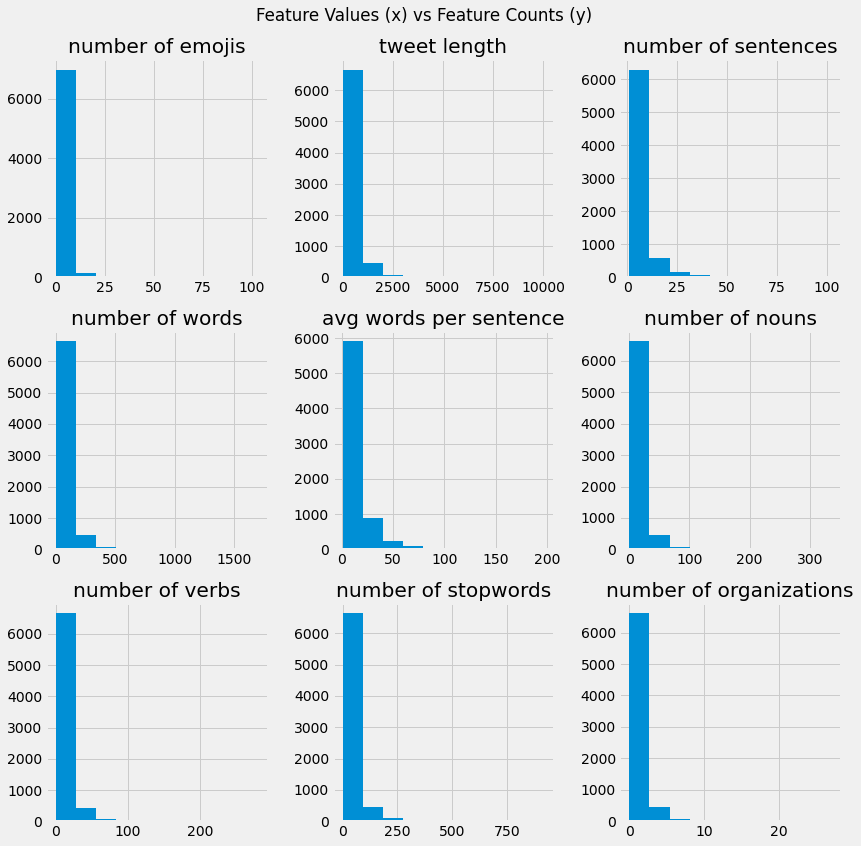

In [29]:
tweet_stocks[engineered_feat].hist(figsize=(12,12))
plt.suptitle('Feature Values (x) vs Feature Counts (y)')
plt.tight_layout()
plt.show()

In [30]:
tweet_stocks[engineered_feat] += 1
tweet_stocks[engineered_feat] = np.log(tweet_stocks[engineered_feat])

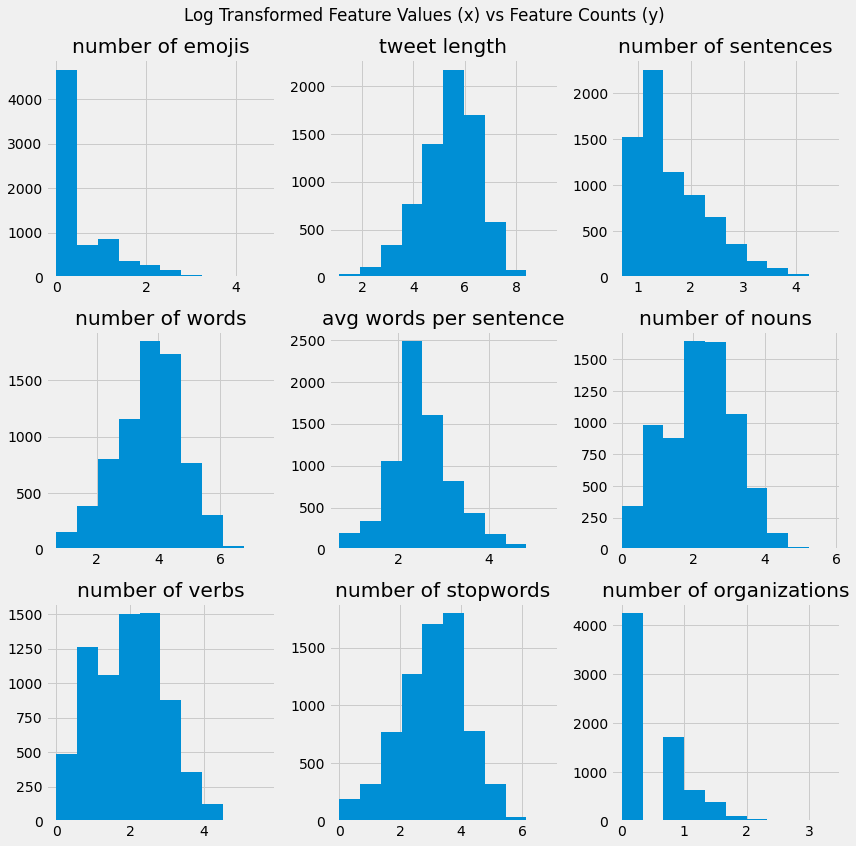

In [31]:
tweet_stocks[engineered_feat].hist(figsize=(12,12))
plt.suptitle('Log Transformed Feature Values (x) vs Feature Counts (y)')
plt.tight_layout()
plt.show()

# Save Pre-Processed Data and Prepare Features for Machine Learning

In [32]:
pd.to_pickle(tweet_stocks, './data/pre_processed_df.pkl')